# LMDZ CM6 ICO : SNOW DURATION 
#### https://forge.ipsl.jussieu.fr/igcmg/wiki/IPSLCM6/IPSL-CM6A-ATM-ICO

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
from pathlib import Path
import calendar as cal #cld ?
import sys
from scipy.interpolate import griddata # Other package for regridding
from scipy import stats
import dask

In [2]:
# For parallelisation
#from dask.distributed import Client
#client = Client()
#client

In [372]:
# Define AREA INVESTIGATED

area='alps'
latlim=(43.5,48.5) 
lonlim=(5,16.5)

# area='him' #(High Montains of Asia)
# latlim = (20, 50)
# lonlim = (60, 110)

# Make a extended version for regridding properly on the edges
latlim_ext = (latlim[0]-5, latlim[-1]+5)
lonlim_ext = (lonlim[0]-5, lonlim[-1]+5)
list_var = ['tas', 'pr', 'snc']
list_res = ['lr', 'mr', 'hr', 'vhr']

In [373]:
#Define TIME PERIOD INVESTIGATED
#(within the [1950-2014] SNOW-CCI data range)

# first_year=1950
first_year=1974
last_year=2014 

In [374]:
# PARAMETERS to compute snow cover duration
scf_threshold=0.1 #A cell is considered "snow-covered" if at least 10% of its surface is snow-covered.

#choose Model resolution : lr, mr, hr, vhr
modres='vhr'

# INPUTS

## 1. Load Observations

#### 1.1. ECAD Temperature

In [6]:
# OPEN ECAD temperature dataset for the first time : MERGE ET Monthly-Average
# file_name_ecad = 'tg_ens_mean_0.1deg_reg_v27.0e.nc'
# folder_name_ecad = '/data/xfain/ECAD'

# ds_temp= xr.open_mfdataset(folder_name_ecad + '/' + file_name_ecad, parallel=True).sel(latitude=slice(latlim_ext[0],latlim_ext[1]),longitude=slice(lonlim_ext[0],lonlim_ext[1])).tg.load()
# ds_temp = ds_temp.rename({'latitude': 'lat','longitude': 'lon'})
# ds_temp_mon = ds_temp.resample(time='M').mean()

# SAVE Monthly Processed ECAD Temperature dataset for Alpine area only
#ds_temp_mon.to_netcdf('/data/xfain/ECAD/tg_ens_mean_0.1deg_reg_v27.0e_monthly.nc')

In [7]:
# OPEN ECAD temperature dataset PreProcessed at MONTHLY Resolution
file_name_ecad_monthly = 'tg_ens_mean_0.1deg_reg_v27.0e_monthly.nc'
folder_name_ecad = '/data/xfain/ECAD/'

ds_temp_mon= xr.open_mfdataset(folder_name_ecad + '/' + file_name_ecad_monthly).tg.load()

#### 1.2. SNOW-CCI datasets

In [375]:
# OPEN Snow-CCI datasets
# CORRECTIONS sur SNOW-CCI data (M. Lalalande)
# Les données d'octobre 1994 sont à ignorer
# Celles de Nov 94 => Janv 95 inexistantes, et il faut créer des index de NaN

folder_name_ESA_CCI_SNOW = '/data/xfain/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/'#monthly_0.25deg/'

path_snow_cci_025 = Path('/data/xfain/ESA_CCI_SNOW/'+'ds_snow_cci_025_'+area+'.nc')
if path_snow_cci_025.is_file():
    print(f'The file {path_snow_cci_025} already exists')
    snc_025 = xr.open_mfdataset('/data/xfain/ESA_CCI_SNOW/'+'ds_snow_cci_025_'+area+'.nc', parallel=True).load()
else:
    print(f'The file {path_snow_cci_025} does not exist')
    ds_025 = xr.open_mfdataset(folder_name_ESA_CCI_SNOW + 'monthly_0.25deg'+'/*.nc', combine='by_coords', parallel=True)
    snow_cci_interp_025 = ds_025['scfg_interp_0.25deg_icefilled']
    snow_cci_interp_025 = snow_cci_interp_025.reindex(time=pd.date_range('1982-01-31T00:00:00.000000000', '2014-12-31T00:00:00.000000000', freq='M'))  # to adapt to your period (import pandas as pd before)
    snow_cci_interp_025.load()
    snow_cci_interp_025.loc['1994-10'] = snow_cci_interp_025.loc['1994-11'].values #snow_cci_interp.loc['1994-11'].values are nan because no values
    snc_025= snow_cci_interp_025.sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).load()
    snc_025.to_netcdf(path_snow_cci_025)

    
path_snow_cci_050 = Path('/data/xfain/ESA_CCI_SNOW/'+'ds_snow_cci_050_'+area+'.nc')
if path_snow_cci_050.is_file():
    print(f'The file {path_snow_cci_050} already exists')
    snc_050 = xr.open_mfdataset('/data/xfain/ESA_CCI_SNOW/'+'ds_snow_cci_050_'+area+'.nc', parallel=True).load()
else:
    print(f'The file {path_snow_cci_050} does not exist')
    ds_050 = xr.open_mfdataset(folder_name_ESA_CCI_SNOW + 'monthly_0.5deg'+'/*.nc', combine='by_coords', parallel=True)
    snow_cci_interp_050 = ds_050['scfg_interp_0.5deg_icefilled']
    snow_cci_interp_050 = snow_cci_interp_050.reindex(time=pd.date_range('1982-01-31T00:00:00.000000000', '2014-12-31T00:00:00.000000000', freq='M'))  # to adapt to your period (import pandas as pd before)
    snow_cci_interp_050.load()
    snow_cci_interp_050.loc['1994-10'] = snow_cci_interp_050.loc['1994-11'].values
    snc_050= snow_cci_interp_050.sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).load()
    snc_050.to_netcdf(path_snow_cci_050)
    

path_snow_cci_100 = Path('/data/xfain/ESA_CCI_SNOW/'+'ds_snow_cci_100_'+area+'.nc')
if path_snow_cci_100.is_file():
    print(f'The file {path_snow_cci_100} already exists')
    snc_100 = xr.open_mfdataset('/data/xfain/ESA_CCI_SNOW/'+'ds_snow_cci_100_'+area+'.nc', parallel=True).load()
else:
    print(f'The file {path_snow_cci_100} deos not exist')
    ds_100 = xr.open_mfdataset(folder_name_ESA_CCI_SNOW + 'monthly_1deg'+'/*.nc', combine='by_coords', parallel=True)
    snow_cci_interp_100 = ds_100['scfg_interp_1deg_icefilled']
    snow_cci_interp_100 = snow_cci_interp_100.reindex(time=pd.date_range('1982-01-31T00:00:00.000000000', '2014-12-31T00:00:00.000000000', freq='M'))  # to adapt to your period (import pandas as pd before)
    snow_cci_interp_100.load()
    snow_cci_interp_100.loc['1994-10'] = snow_cci_interp_100.loc['1994-11'].values
    snc_100= snow_cci_interp_100.sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).load()
    snc_100.to_netcdf(path_snow_cci_100)


path_snow_cci_raw = Path('/data/xfain/ESA_CCI_SNOW/'+'ds_snow_cci_raw_'+area+'.nc')
if path_snow_cci_raw.is_file():
    print(f'The file {path_snow_cci_raw} already exists')
    snc_raw = xr.open_mfdataset('/data/xfain/ESA_CCI_SNOW/'+'ds_snow_cci_raw_'+area+'.nc', parallel=True).load()
else:
    print(f'The file {path_snow_cci_raw} does not exist')
    ds_raw = xr.open_mfdataset(folder_name_ESA_CCI_SNOW + 'monthly'+'/*.nc', combine='by_coords', parallel=True)
    snow_cci_raw = ds_raw['scfg_interp']
    snc_raw = snow_cci_raw.sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).load()
    snc_raw.to_netcdf(path_snow_cci_raw)
# Available résolution GapFilled (directory): monthly_0.1deg  monthly_0.25deg  monthly_0.5deg  monthly_1deg
# AW DATA before GapFilling: /data/xfain/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly$

The file /data/xfain/ESA_CCI_SNOW/ds_snow_cci_025_alps.nc does not exist
The file /data/xfain/ESA_CCI_SNOW/ds_snow_cci_050_alps.nc does not exist
The file /data/xfain/ESA_CCI_SNOW/ds_snow_cci_100_alps.nc deos not exist
The file /data/xfain/ESA_CCI_SNOW/ds_snow_cci_raw_alps.nc does not exist


In [376]:
snc_list =[snc_025,snc_050,snc_100]

## 2. Load Model outputs

In [377]:
# Directory where LMDZ extracted output data are saved
ldmz_output_path='/data/xfain/LMDZ_CM6_ICO'

In [378]:
#List LR files # Monthly resolution
file_name_lr_tas = 'tas_Amon_IPSL-CM6A-ATM-ICO-LR_highresSST-present_r1i1p1f1_gr_*.nc'
file_name_lr_pr = 'pr_Amon_IPSL-CM6A-ATM-ICO-LR_highresSST-present_r1i1p1f1_gr_*.nc'
file_name_lr_snc = 'snc_LImon_IPSL-CM6A-ATM-ICO-LR_highresSST-present_r1i1p1f1_gr_*.nc'
folder_name_LR_ATM = '/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-LR-01.sponge.run.01/CMIP6/ATM'
folder_name_LR_SRF = '/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-LR-01.sponge.run.01/CMIP6/SRF'

In [379]:
#List MR files # Monthly resolution
file_name_mr_tas = 'tas_Amon_IPSL-CM6A-ATM-ICO-MR_highresSST-present_r1i1p1f1_gr_*.nc'
file_name_mr_pr = 'pr_Amon_IPSL-CM6A-ATM-ICO-MR_highresSST-present_r1i1p1f1_gr_*.nc'
file_name_mr_snc = 'snc_LImon_IPSL-CM6A-ATM-ICO-MR_highresSST-present_r1i1p1f1_gr_*.nc'
folder_name_MR_ATM = '/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-MR-01.sponge.run.01/CMIP6/ATM'
folder_name_MR_SRF = '/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-MR-01.sponge.run.01/CMIP6/SRF'

In [380]:
#List HR files # Monthly resolution
file_name_hr_tas = 'tas_Amon_IPSL-CM6A-ATM-ICO-HR_highresSST-present_r1i1p1f1_gr_*.nc'
file_name_hr_pr = 'pr_Amon_IPSL-CM6A-ATM-ICO-HR_highresSST-present_r1i1p1f1_gr_*.nc'
file_name_hr_snc = 'snc_LImon_IPSL-CM6A-ATM-ICO-HR_highresSST-present_r1i1p1f1_gr_*.nc'
folder_name_HR_ATM = '/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-HR.sponge.run.01/CMIP6/ATM'
folder_name_HR_SRF = '/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-HR.sponge.run.01/CMIP6/SRF'

In [381]:
#List VHR files # Monthly resolution
file_name_vhr_tas = 'tas_Amon_IPSL-CM6A-ATM-ICO-VHR_highresSST-present_r1i1p1f1_gr_*.nc'
file_name_vhr_pr = 'pr_Amon_IPSL-CM6A-ATM-ICO-VHR_highresSST-present_r1i1p1f1_gr_*.nc'
file_name_vhr_snc = 'snc_LImon_IPSL-CM6A-ATM-ICO-VHR_highresSST-present_r1i1p1f1_gr_*.nc'
folder_name_VHR_ATM = '/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-VHR.sponge.run.01/CMIP6/ATM'
folder_name_VHR_SRF = '/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-VHR.sponge.run.01/CMIP6/SRF'

In [382]:
#Open and combine all LR Monthly dataset
path_tas = Path(ldmz_output_path+'/ds_lr_tas_'+area+'.nc')
path_pr = Path(ldmz_output_path+'/ds_lr_pr_'+area+'.nc')
path_snc = Path(ldmz_output_path+'/ds_lr_snc_'+area+'.nc')

if path_tas.is_file():
    print(f'The file {path_tas} already exists')
    ds_lr_tas = xr.open_mfdataset(ldmz_output_path+'/ds_lr_tas_'+area+'.nc', parallel=True).tas.load()
else:
    print(f'The file {path_tas} does not exist')
    print(f'Extracting the LR TAS data')
    ds_lr_tas= xr.open_mfdataset(folder_name_LR_ATM + '/' + file_name_lr_tas, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).tas.load()
    ds_lr_tas.to_netcdf(ldmz_output_path+'/ds_lr_tas_'+area+'.nc')

if path_pr.is_file():
    print(f'The file {path_pr} already exists')
    ds_lr_pr = xr.open_mfdataset(ldmz_output_path+'/ds_lr_pr_'+area+'.nc', parallel=True).pr.load()
else:
    print(f'The file {path_pr} does not exist')
    print(f'Extracting the LR PR data')
    ds_lr_pr= xr.open_mfdataset(folder_name_LR_ATM + '/' + file_name_lr_pr, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).pr.load()
    ds_lr_pr.to_netcdf(ldmz_output_path+'/ds_lr_pr_'+area+'.nc')

if path_snc.is_file():
    print(f'The file {path_snc} already exists')
    ds_lr_snc = xr.open_mfdataset(ldmz_output_path+'/ds_lr_snc_'+area+'.nc', parallel=True).snc.load()
else:
    print(f'The file {path_snc} does not exist')
    print(f'Extracting the LR SNC data')
    ds_lr_snc= xr.open_mfdataset(folder_name_LR_SRF + '/' + file_name_lr_snc, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).snc.load()
    ds_lr_snc.to_netcdf(ldmz_output_path+'/ds_lr_snc_'+area+'.nc')

The file /data/xfain/LMDZ_CM6_ICO/ds_lr_tas_alps.nc does not exist
Extracting the LR TAS data
The file /data/xfain/LMDZ_CM6_ICO/ds_lr_pr_alps.nc does not exist
Extracting the LR PR data
The file /data/xfain/LMDZ_CM6_ICO/ds_lr_snc_alps.nc does not exist
Extracting the LR SNC data


In [383]:
#Open and combine all MR Monthly dataset
path_tas = Path(ldmz_output_path+'/ds_mr_tas_'+area+'.nc')
path_pr = Path(ldmz_output_path+'/ds_mr_pr_'+area+'.nc')
path_snc = Path(ldmz_output_path+'/ds_mr_snc_'+area+'.nc')

if path_tas.is_file():
    print(f'The TAS file {path_tas} already exists')
    ds_mr_tas = xr.open_mfdataset(ldmz_output_path+'/ds_mr_tas_'+area+'.nc', parallel=True).tas.load()
else:
    print(f'The file {path_tas} does not exist')
    print(f'Extracting the MR TAS data')
    ds_mr_tas= xr.open_mfdataset(folder_name_MR_ATM + '/' + file_name_mr_tas, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).tas.load()
    ds_mr_tas.to_netcdf(ldmz_output_path+'/ds_mr_tas_'+area+'.nc')
    
if path_pr.is_file():
    print(f'The  file {path_pr} already exists')
    ds_mr_pr = xr.open_mfdataset(ldmz_output_path+'/ds_mr_pr_'+area+'.nc', parallel=True).pr.load()
else:
    print(f'The file {path_pr} does not exist')
    print(f'Extracting the MR PR data')
    ds_mr_pr= xr.open_mfdataset(folder_name_MR_ATM + '/' + file_name_mr_pr, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).pr.load()
    ds_mr_pr.to_netcdf(ldmz_output_path+'/ds_mr_pr_'+area+'.nc')
    
if path_snc.is_file():
    print(f'The file {path_snc} already exists')
    ds_mr_snc = xr.open_mfdataset(ldmz_output_path+'/ds_mr_snc_'+area+'.nc', parallel=True).snc.load()
else:
    print(f'The file {path_snc} does not exist')
    print(f'Extracting the MR SNC data')
    ds_mr_snc= xr.open_mfdataset(folder_name_MR_SRF + '/' + file_name_mr_snc, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).snc.load()
    ds_mr_snc.to_netcdf(ldmz_output_path+'/ds_mr_snc_'+area+'.nc')

The file /data/xfain/LMDZ_CM6_ICO/ds_mr_tas_alps.nc does not exist
Extracting the MR TAS data
The file /data/xfain/LMDZ_CM6_ICO/ds_mr_pr_alps.nc does not exist
Extracting the MR PR data
The file /data/xfain/LMDZ_CM6_ICO/ds_mr_snc_alps.nc does not exist
Extracting the MR SNC data


In [384]:
#Open and combine all HR Monthly dataset
path_tas = Path(ldmz_output_path+'/ds_hr_tas_'+area+'.nc')
path_pr = Path(ldmz_output_path+'/ds_hr_pr_'+area+'.nc')
path_snc = Path(ldmz_output_path+'/ds_hr_snc_'+area+'.nc')

if path_tas.is_file():
    print(f'The file {path_tas} already exists')
    ds_hr_tas = xr.open_mfdataset(ldmz_output_path+'/ds_hr_tas_'+area+'.nc', parallel=True).tas.load()
else:
    print(f'The HR file {path_tas} does not exist')
    print(f'Extracting the HR TAS data')
    ds_hr_tas= xr.open_mfdataset(folder_name_HR_ATM + '/' + file_name_hr_tas, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).tas.load()
    ds_hr_tas.to_netcdf(ldmz_output_path+'/ds_hr_tas_'+area+'.nc')
    
if path_pr.is_file():
    print(f'The file {path_pr} already exists')
    ds_hr_pr = xr.open_mfdataset(ldmz_output_path+'/ds_hr_pr_'+area+'.nc', parallel=True).pr.load()
else:
    print(f'The file {path_pr} does not exist')
    print(f'Extracting the HR PR data')
    ds_hr_pr= xr.open_mfdataset(folder_name_HR_ATM + '/' + file_name_hr_pr, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).pr.load()
    ds_hr_pr.to_netcdf(ldmz_output_path+'/ds_hr_pr_'+area+'.nc')
    
if path_snc.is_file():
    print(f'The file {path_snc} already exists')
    ds_hr_snc = xr.open_mfdataset(ldmz_output_path+'/ds_hr_snc_'+area+'.nc', parallel=True).snc.load()
else:
    print(f'The file {path_snc} does not exist')
    print(f'Extracting the HR SNC data')
    ds_hr_snc= xr.open_mfdataset(folder_name_HR_SRF + '/' + file_name_hr_snc, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).snc.load()
    ds_hr_snc.to_netcdf(ldmz_output_path+'/ds_hr_snc_'+area+'.nc')

The HR file /data/xfain/LMDZ_CM6_ICO/ds_hr_tas_alps.nc does not exist
Extracting the HR TAS data
The file /data/xfain/LMDZ_CM6_ICO/ds_hr_pr_alps.nc does not exist
Extracting the HR PR data
The file /data/xfain/LMDZ_CM6_ICO/ds_hr_snc_alps.nc does not exist
Extracting the HR SNC data


In [385]:
#Open and combine all VHR Monthly dataset
path_tas = Path(ldmz_output_path+'/ds_vhr_tas_'+area+'.nc')
path_pr = Path(ldmz_output_path+'/ds_vhr_pr_'+area+'.nc')
path_snc = Path(ldmz_output_path+'/ds_vhr_snc_'+area+'.nc')

if path_tas.is_file():
    print(f'The file {path_tas} already exists')
    ds_vhr_tas = xr.open_mfdataset(ldmz_output_path+'/ds_vhr_tas_'+area+'.nc', parallel=True).tas.load()
else:
    print(f'The file {path_tas} does not exist')
    print(f'Extracting the VHR TAS data')
    ds_vhr_tas= xr.open_mfdataset(folder_name_VHR_ATM + '/' + file_name_vhr_tas, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).tas.load()
    ds_vhr_tas.to_netcdf(ldmz_output_path+'/ds_vhr_tas_'+area+'.nc')
    
if path_pr.is_file():
    print(f'The file {path_pr} already exists')
    ds_vhr_pr = xr.open_mfdataset(ldmz_output_path+'/ds_vhr_pr_'+area+'.nc', parallel=True).pr.load()
else:
    print(f'The file {path_pr} does not exist')
    print(f'Extracting the VHR PR data')
    ds_vhr_pr= xr.open_mfdataset(folder_name_VHR_ATM + '/' + file_name_vhr_pr, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).pr.load()
    ds_vhr_pr.to_netcdf(ldmz_output_path+'/ds_vhr_pr_'+area+'.nc')
    
if path_snc.is_file():
    print(f'The file {path_snc} already exists')
    ds_vhr_snc = xr.open_mfdataset(ldmz_output_path+'/ds_vhr_snc_'+area+'.nc', parallel=True).snc.load()
else:
    print(f'The file {path_snc} does not exist')
    print(f'Extracting the VHR SNC data')
    ds_vhr_snc= xr.open_mfdataset(folder_name_VHR_SRF + '/' + file_name_vhr_snc, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).snc.load()
    ds_vhr_snc.to_netcdf(ldmz_output_path+'/ds_vhr_snc_'+area+'.nc')

The file /data/xfain/LMDZ_CM6_ICO/ds_vhr_tas_alps.nc does not exist
Extracting the VHR TAS data
The file /data/xfain/LMDZ_CM6_ICO/ds_vhr_pr_alps.nc does not exist
Extracting the VHR PR data
The file /data/xfain/LMDZ_CM6_ICO/ds_vhr_snc_alps.nc does not exist
Extracting the VHR SNC data


In [386]:
ds_lr = xr.concat((ds_lr_tas-273.15, ds_lr_pr*86400, ds_lr_snc), pd.Index(list_var, name='var'))
ds_mr = xr.concat((ds_mr_tas-273.15, ds_mr_pr*86400, ds_mr_snc), pd.Index(list_var, name='var'))
ds_hr = xr.concat((ds_hr_tas-273.15, ds_hr_pr*86400, ds_hr_snc), pd.Index(list_var, name='var'))
ds_vhr = xr.concat((ds_vhr_tas-273.15, ds_vhr_pr*86400, ds_vhr_snc), pd.Index(list_var, name='var'))
    
ds_list = [ds_lr, ds_mr, ds_hr, ds_vhr]

In [387]:
#List SNC Files # Daiy resolution
file_name_lr_day_snc = 'snc_day_IPSL-CM6A-ATM-ICO-LR_highresSST-present_r1i1p1f1_gr_*.nc'
file_name_mr_day_snc = 'snc_day_IPSL-CM6A-ATM-ICO-MR_highresSST-present_r1i1p1f1_gr_*.nc'
file_name_hr_day_snc = 'snc_day_IPSL-CM6A-ATM-ICO-HR_highresSST-present_r1i1p1f1_gr_*.nc'
file_name_vhr_day_snc = 'snc_day_IPSL-CM6A-ATM-ICO-VHR_highresSST-present_r1i1p1f1_gr_*.nc'

In [388]:
#Open Daily snc Files
path_snc_day_lr = Path(ldmz_output_path+'/ds_lr_day_snc_'+area+'.nc')
path_snc_day_mr = Path(ldmz_output_path+'/ds_mr_day_snc_'+area+'.nc')
path_snc_day_hr = Path(ldmz_output_path+'/ds_hr_day_snc_'+area+'.nc')
path_snc_day_vhr = Path(ldmz_output_path+'/ds_vhr_day_snc_'+area+'.nc')

#LR dataset
if path_snc_day_lr.is_file():
    print(f'The file {path_snc_day_lr} already exists')
    ds_lr_day_snc = xr.open_mfdataset(ldmz_output_path+'/ds_lr_snc_'+area+'.nc', parallel=True).snc.load()
else:
    print(f'The file {path_snc_day_lr} does not exist')
    print(f'Extracting the daily LR snc data')
    ds_lr_day_snc= xr.open_mfdataset(folder_name_LR_SRF + '/' + file_name_lr_day_snc, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).snc.load()
    ds_lr_day_snc.to_netcdf(ldmz_output_path+'/ds_lr_day_snc_'+area+'.nc')

#MR dataset
if path_snc_day_mr.is_file():
    print(f'The file {path_snc_day_mr} already exists')
    ds_mr_day_snc = xr.open_mfdataset(ldmz_output_path+'/ds_mr_snc_'+area+'.nc', parallel=True).snc.load()
else:
    print(f'The file {path_snc_day_mr} does not exist')
    print(f'Extracting the daily MR snc data')
    ds_mr_day_snc= xr.open_mfdataset(folder_name_MR_SRF + '/' + file_name_mr_day_snc, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).snc.load()
    ds_mr_day_snc.to_netcdf(ldmz_output_path+'/ds_mr_day_snc_'+area+'.nc')

#HR dataset
if path_snc_day_hr.is_file():
    print(f'The file {path_snc_day_hr} already exists')
    ds_hr_day_snc = xr.open_mfdataset(ldmz_output_path+'/ds_hr_snc_'+area+'.nc', parallel=True).snc.load()
else:
    print(f'The file {path_snc_day_hr} does not exist')
    print(f'Extracting the daily HR snc data')
    ds_hr_day_snc= xr.open_mfdataset(folder_name_HR_SRF + '/' + file_name_hr_day_snc, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).snc.load()
    ds_hr_day_snc.to_netcdf(ldmz_output_path+'/ds_hr_day_snc_'+area+'.nc')

#VHR dataset 
if path_snc_day_vhr.is_file():
    print(f'The file {path_snc_day_vhr} already exists')
    ds_vhr_day_snc = xr.open_mfdataset(ldmz_output_path+'/ds_vhr_snc_'+area+'.nc', parallel=True).snc.load()
else:
    print(f'The file {path_snc_day_vhr} does not exist')
    print(f'Extracting the daily VHR snc data')
    ds_vhr_day_snc= xr.open_mfdataset(folder_name_VHR_SRF + '/' + file_name_vhr_day_snc, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).snc.load()
    ds_vhr_day_snc.to_netcdf(ldmz_output_path+'/ds_vhr_day_snc_'+area+'.nc')

The file /data/xfain/LMDZ_CM6_ICO/ds_lr_day_snc_alps.nc does not exist
Extracting the daily LR snc data
The file /data/xfain/LMDZ_CM6_ICO/ds_mr_day_snc_alps.nc does not exist
Extracting the daily MR snc data
The file /data/xfain/LMDZ_CM6_ICO/ds_hr_day_snc_alps.nc does not exist
Extracting the daily HR snc data
The file /data/xfain/LMDZ_CM6_ICO/ds_vhr_day_snc_alps.nc does not exist
Extracting the daily VHR snc data


## 3. Load Orography

#### 3.1 LMDZ-ICO-CM6 topography

In [389]:
file_name_lr_orog ='orog_fx_IPSL-CM6A-ATM-ICO-LR_highresSST-present_r1i1p1f1_gr.nc'
file_name_mr_orog ='orog_fx_IPSL-CM6A-ATM-ICO-MR_highresSST-present_r1i1p1f1_gr.nc'
file_name_hr_orog ='orog_fx_IPSL-CM6A-ATM-ICO-HR_highresSST-present_r1i1p1f1_gr.nc'
file_name_vhr_orog ='orog_fx_IPSL-CM6A-ATM-ICO-VHR_highresSST-present_r1i1p1f1_gr.nc'

In [390]:
ds_lr_orog= xr.open_mfdataset(folder_name_LR_ATM + '/' + file_name_lr_orog).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).orog.load()
ds_mr_orog= xr.open_mfdataset(folder_name_MR_ATM + '/' + file_name_mr_orog).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).orog.load()
ds_hr_orog= xr.open_mfdataset(folder_name_HR_ATM + '/' + file_name_hr_orog).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).orog.load()
ds_vhr_orog= xr.open_mfdataset(folder_name_VHR_ATM + '/' + file_name_vhr_orog).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).orog.load()

#### 3.2 GMTED2010 topography

In [391]:
ds_topo = xr.open_dataset('/data/mmenegoz/GMTED2010/GMTED2010_15n015_00625deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=slice(latlim[0], latlim[-1]), lon=slice(lonlim[0], lonlim[-1]))
elevation = ds_topo.elevation
elevation_std = ds_topo.elevation_stddev

## 4. Compute snow duration

In [392]:

months_per_year=12

In [393]:
#time_nbdays = pd.date_range(start=str(first_year)+'-01',end=str(last_year+1)+'-12',freq='M')
time_nbdays = pd.date_range(start=str(first_year)+'-01-01',end=str(last_year+1)+'-01-01',freq='M')
reference_time = pd.Timestamp(str(first_year)+'-01')

if modres == 'lr':
    ds_day_snc = ds_lr_day_snc
    dsi_topo = ds_lr_orog
elif modres == 'mr':
    ds_day_snc = ds_mr_day_snc
    dsi_topo = ds_mr_orog
elif modres == 'hr':
    ds_day_snc = ds_hr_day_snc
    dsi_topo = ds_hr_orog
else :
    ds_day_snc = ds_vhr_day_snc
    dsi_topo = ds_vhr_orog

In [394]:
#time_nbdays = nombre de jours enneigés sur un mois
# Initialise the array 12 month per year nbdays array if these data do not exist already

path_nbdays = Path(ldmz_output_path+'/LMDZ_'+modres+'_'+area+'_snow_nbdays.nc')

ds_nbdays = xr.Dataset({
    'nbdays': xr.DataArray(
        data=np.full((ds_day_snc.lat.shape[0],ds_day_snc.lon.shape[0],time_nbdays.shape[0]), np.nan),
        dims=["lat", "lon", "time"],
        coords=dict(
            lat=(["lat"], ds_day_snc.lat),
            lon=(["lon"], ds_day_snc.lon),
            time=time_nbdays,
            reference_time=reference_time,
        ),
        name='nbdays',
        attrs=dict(
            description="snow cover duration",
            units="days month-1",
        ),
        ),
    },
    attrs = {'documentation': 'Snow cover duration from LDMZ-CM6-ICO snow cover fraction outputs.'}
)  
ds_nbdays.load()

<xarray.Dataset>
Dimensions:         (lat: 60, lon: 87, time: 492)
Coordinates:
  * lat             (lat) float32 38.67872 38.92907 ... 53.198887 53.449234
  * lon             (lon) float32 0.0 0.25 0.5 0.75 ... 20.75 21.0 21.25 21.5
  * time            (time) datetime64[ns] 1974-01-31 1974-02-28 ... 2014-12-31
    reference_time  datetime64[ns] 1974-01-01
Data variables:
    nbdays          (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    documentation:  Snow cover duration from LDMZ-CM6-ICO snow cover fraction...

In [395]:
#PB si fichier existe déjà, il ne le remplace pas

# nbdays calculation (From Martin)
# 1. for each year and month, we select the gridcell with snc > threshold=0.1 (for which the gridcell is considered snow covered.
# 2. sum the snow covered days for each month 

for iyear, year in enumerate(range(first_year, last_year+1, 1)):
    for imonth in range(1,months_per_year+1,1):
        numday_month=cal.monthrange(year, imonth)[1]
        ds_tmp=ds_day_snc.sel(time=str(year)+'-'+str(imonth)) #ds_lr_day_snc
        binary=xr.where(ds_tmp > scf_threshold, 1., 0.)
        xnbdays=binary.sum(dim='time',skipna=True)
        ds_nbdays.sel(time=str(year)+'-'+str(imonth)).nbdays[:,:,0]=xnbdays
ds_nbdays.to_netcdf(ldmz_output_path+'/LMDZ_'+modres+'_'+area+'_'+str(first_year)+'_'+str(last_year)+'_snow_nbdays.nc')

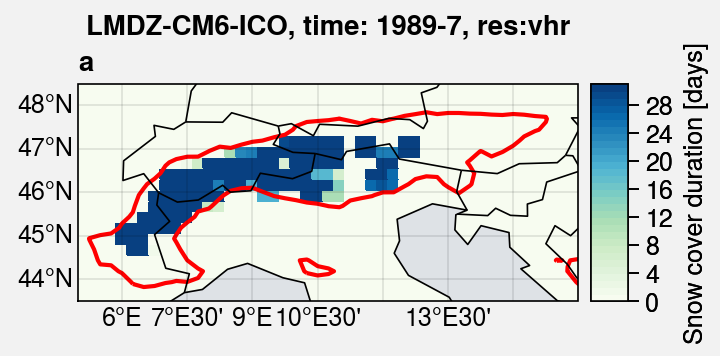

In [396]:
# Check the result for one specific date
time_check='1989-7'
levels_nbdays=plot.arange(0,31,1)
levels_elev=plot.arange(1000,1000,1000)
cmap='GnBu'
levels=plot.arange(0, 100, 5)

fig,axs = plot.subplots(nrows=1, ncols=1, proj='cyl')
axs[0,0].pcolormesh(ds_nbdays.nbdays.sel(time=time_check)[:,:,0], levels=levels_nbdays, cmap=cmap, colorbar='r', 
                    colorbar_kw={'label': 'Snow cover duration [days]'})
axs[0,0].contour(dsi_topo,levels=levels_elev,color='red')

axs.format(
    suptitle='LMDZ-CM6-ICO, time: '+time_check+', res:'+modres,
    latlim=latlim, lonlim=lonlim,
    coast=True, ocean=True, 
    borders=True, labels=True,
    abc=True,
    oceancolor='gray3'
)

## 5. Compute Snow duration monthly trends

In [416]:
# check locals trends
#COL de PORTE
lon_loc=5.7671; lat_loc = 45.2898
location_name='Col de Porte'

#COL du LAUTARET
# lon_loc=6.4; lat_loc=45.0
# location_name='Col du Lautaret'

#EVEREST
# lon_loc=86.92; lat_loc=28.0
# location_name='Everest Summit'
#Need more relevant Him locations !

nbdays_loc=ds_nbdays.nbdays.sel(lon=lon_loc, lat=lat_loc, method="nearest")

# For comparison with real site altitude
elevation_loc=dsi_topo.sel(lon=lon_loc, lat=lat_loc, method="nearest")
print('Altitude of grid cell containing '+location_name+':') 
elevation_loc #Note for self : how to extract the elevation_loc[0] value?

Altitude of grid cell containing Col de Porte:


<xarray.DataArray 'orog' ()>
array(657.4418, dtype=float32)
Coordinates:
    lat      float32 45.18776
    lon      float32 5.75
Attributes:
    long_name:         Surface Altitude
    units:             m
    online_operation:  once
    cell_methods:      area: mean
    standard_name:     surface_altitude
    description:       height above the geoid; as defined here, "the geoid" i...
    history:           none
    cell_measures:     area: areacella

In [417]:
##### Monthly arrays and computing mean
monthly_nbdays_loc=np.empty(shape=(int(nbdays_loc.shape[0]/months_per_year),months_per_year), dtype=float)

for imonth in range(0,months_per_year,1):
    monthly_nbdays_loc[:,imonth]=nbdays_loc.sel(time=ds_nbdays.time.dt.month.isin([imonth+1]))
    
monthly_mean_nbdays_loc=np.mean(monthly_nbdays_loc,axis=0)

In [418]:
# Computing trends
slope_nbdays_loc=np.full(months_per_year,np.nan)
pvalue_nbdays_loc=np.full(months_per_year,np.nan)
intercept_nbdays_loc=np.full(months_per_year,np.nan)
for imonth in range(months_per_year):
    linregress_nbdays_loc = stats.linregress(range(monthly_nbdays_loc.shape[0]), monthly_nbdays_loc[:,imonth])
    slope_nbdays_loc[imonth] = linregress_nbdays_loc.slope
    intercept_nbdays_loc[imonth] = linregress_nbdays_loc.intercept
    pvalue_nbdays_loc[imonth] = linregress_nbdays_loc.pvalue

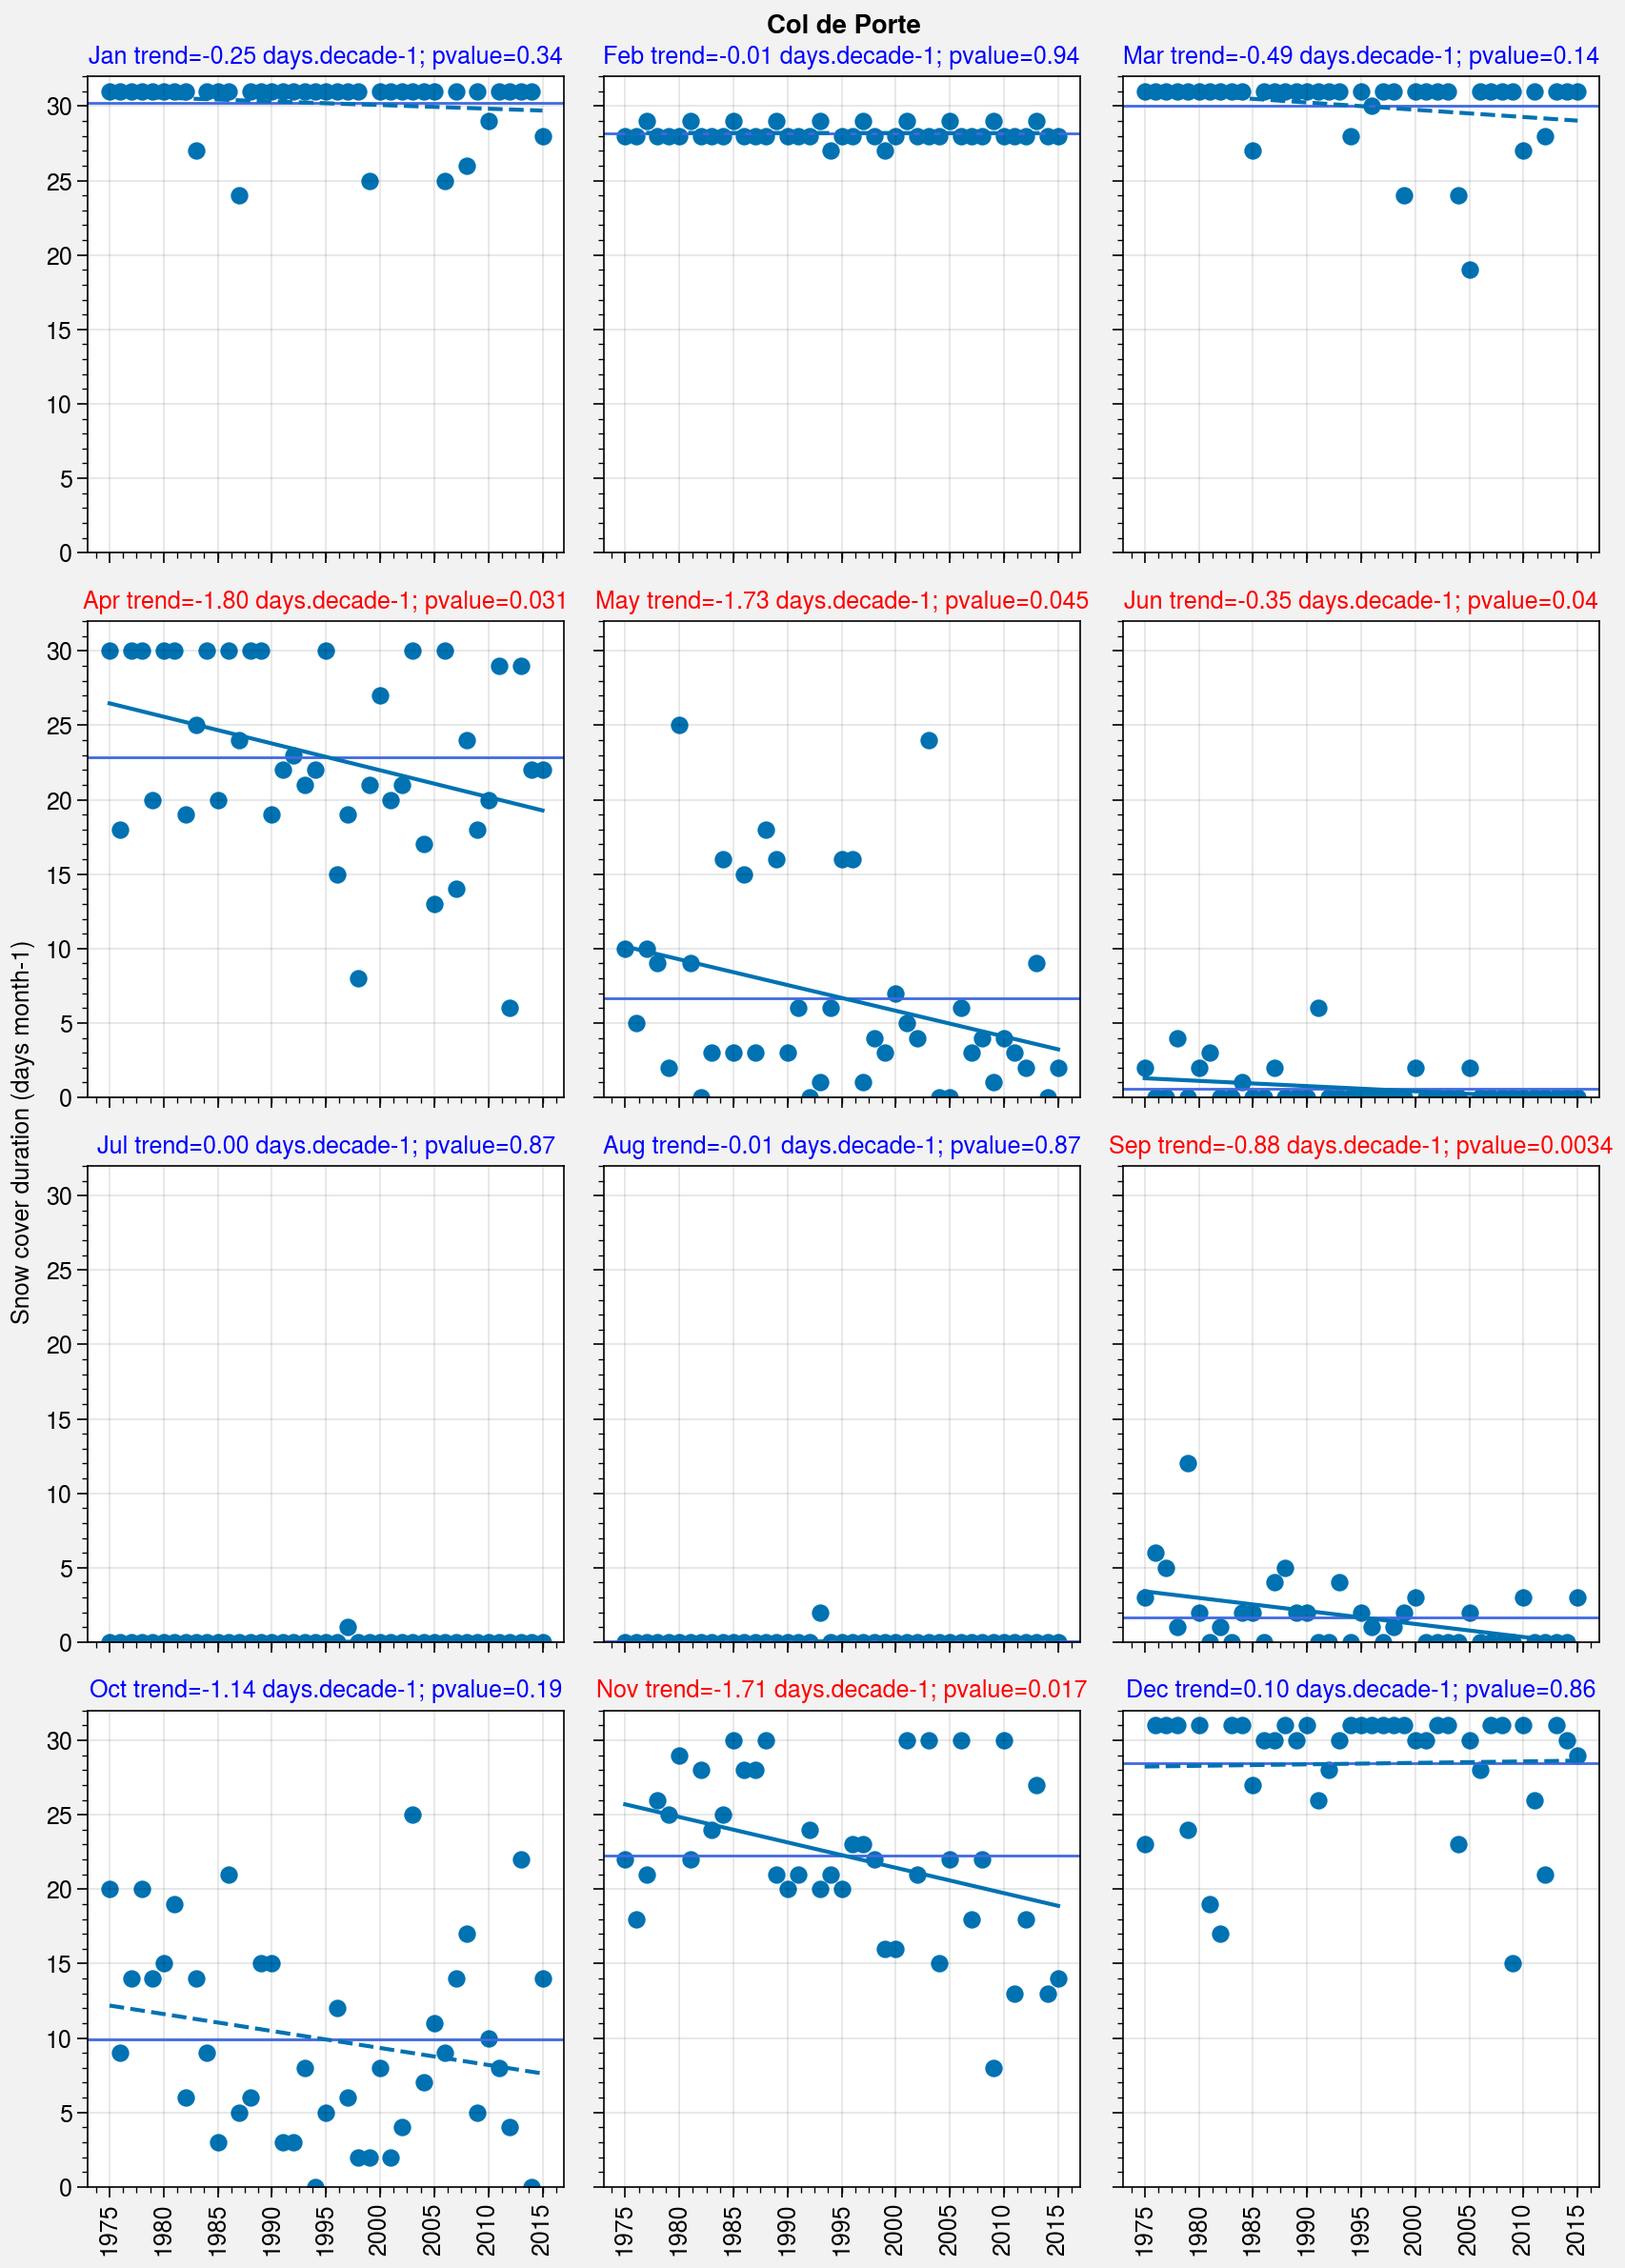

In [419]:
# Plot local timeseries and trends for all the months
fig, axs = plot.subplots(nrows=4, ncols=3)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
year_time = pd.date_range(start=str(first_year),end=str(last_year+1),freq='Y')
index=np.arange(0,year_time.shape[0])

for i, ax in enumerate(axs):
    m = ax.axhline(monthly_mean_nbdays_loc[i], color='royalblue', linewidth=1)  # monthly mean
    m = ax.scatter(year_time,monthly_nbdays_loc[:,i])
    if pvalue_nbdays_loc[i]<0.05:
        signif='solid'
        color='red'
    else:
        signif='dashed'
        color='blue'
    m = ax.plot(year_time,intercept_nbdays_loc[i]+slope_nbdays_loc[i]*index,linestyle=signif)
    ax.format(title=f"{months[i]} trend={slope_nbdays_loc[i]*10:.2f} days.decade-1; pvalue={pvalue_nbdays_loc[i]:.2g}",titlesize=9,titlecolor=color)
    ax.set_ylim(0, 32) 
axs.format(suptitle=location_name, ylabel='Snow cover duration (days month-1)')

## 6. Compute Snow duration monthly spatial trends

In [401]:
# Monthly arrays and computing mean
monthly_nbdays=np.empty(shape=(ds_nbdays.nbdays.shape[0],ds_nbdays.nbdays.shape[1],months_per_year,int(ds_nbdays.nbdays.shape[2]/months_per_year)), dtype=float)
for imonth in range(0,months_per_year,1):
    monthly_nbdays[:,:,imonth,:]=ds_nbdays.nbdays.sel(time=ds_nbdays.time.dt.month.isin([imonth+1]))
monthly_mean_nbdays=np.mean(monthly_nbdays,axis=3)

In [402]:
# Computing trends
slope_nbdays=np.full(monthly_nbdays.shape[0:3],np.nan)
pvalue_nbdays=np.full(monthly_nbdays.shape[0:3],np.nan)
monthly_nbdays_nonan=monthly_nbdays # Replacing the missing values by the mean before computing the trend
for lat in range(monthly_nbdays.shape[0]):
    for lon in range(monthly_nbdays.shape[1]):
        for imonth in range(months_per_year):
            monthly_nbdays_nonan[lat,lon,imonth,:][np.isnan(monthly_nbdays[lat,lon,imonth,:])]=monthly_mean_nbdays[lat,lon,imonth]
            linregress_nbdays = stats.linregress(range(monthly_nbdays.shape[3]), monthly_nbdays[lat,lon,imonth,:])
            slope_nbdays[lat][lon][imonth] = linregress_nbdays.slope
            pvalue_nbdays[lat][lon][imonth] = linregress_nbdays.pvalue

In [403]:
cmap_mean='GnBu'
cmap_trend='BrBg'

i=0
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x153d6f76fb30> >
i=1
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x153d6f754770> >
i=2
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x153d6fa24ea0> >
i=3
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x153dbc090ae0> >
i=4
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x153dbc165950> >
i=5
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x153d8c086bd0> >
i=6
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x153dbc06af90> >
i=7
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x153dbc1868b0> >
i=8
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x153dbcbab090> >
i=9
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x153dbc05adb0> >
i=10
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x153d8c0146d0> >
i=11
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x153dbc097450> >


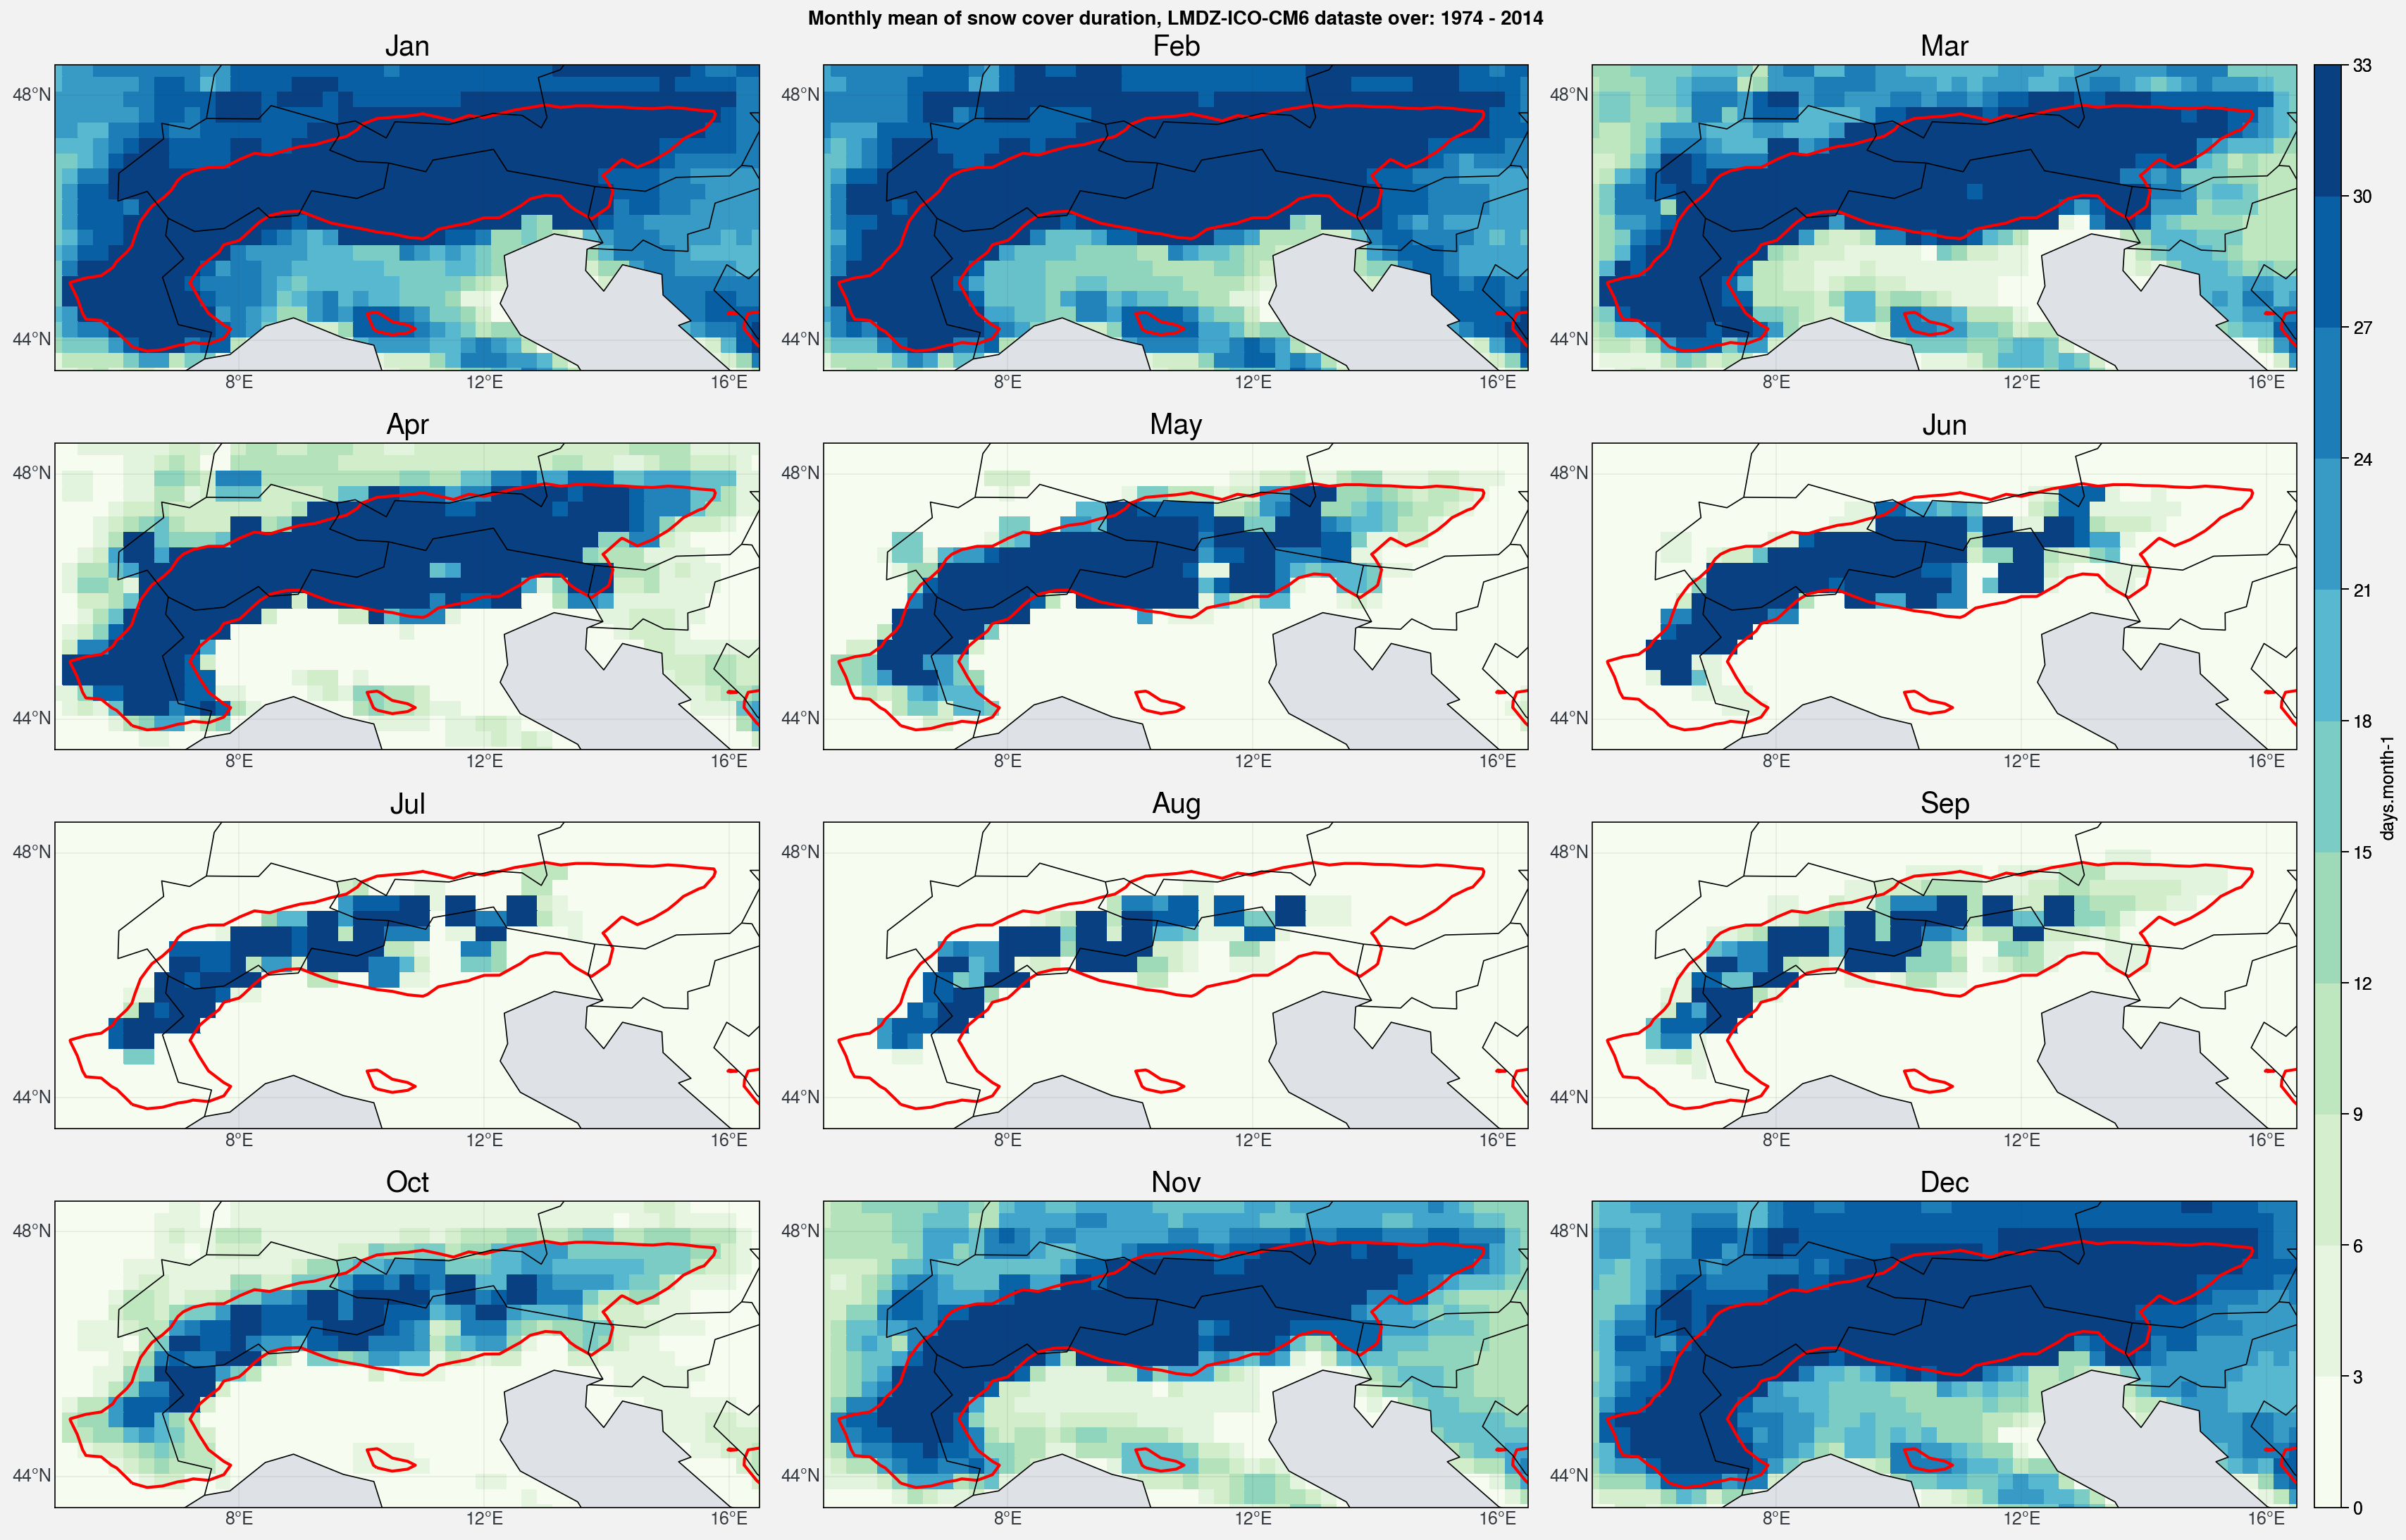

In [404]:
# Producing the map of the snow cover duration mean

f, axs = plot.subplots(proj='cyl',ncols=3, nrows=4, share=1, axwidth=5)
for i, ax in enumerate(axs):
    print('i='+str(i))
    print('ax='+str(ax))
    m = ax.pcolormesh(
        ds_nbdays.lon,ds_nbdays.lat,
        monthly_mean_nbdays[:,:,i],#*mask_snow[:,:,i],
        #levels=levels,
        cmap=cmap_mean
    )
    p = ax.contour(
       dsi_topo.lon,dsi_topo.lat,dsi_topo,
       levels=levels_elev,color='red',
   )
    ax.format(title=months[i],titlesize='20px')#,labels=True)
    
f.colorbar(m, label= 'days.month-1')

axs.format(
    gridlinewidth=0.1, gridcolor='gray8', gridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Monthly mean of snow cover duration, LMDZ-ICO-CM6 dataste over: "+str(first_year)+" - "+str(last_year),
    lonlines=4, latlines=4, abc=False, latlim=latlim,lonlim=lonlim,
)

In [405]:
# Masking non-significative signals
signif=np.where(pvalue_nbdays<0.05,True,False)

In [406]:
# Masking values where there is no snow
mask_snow=np.where(monthly_mean_nbdays<3,np.nan,True)

In [407]:
# Levels for the plot
levels=plot.arange(-6,6,1)
factor=10 # degree per decade

i=0
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x153d8de92860> >
i=1
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x153d8de926d0> >
i=2
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x153d8de924f0> >
i=3
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x153d8de92220> >
i=4
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x153d8de92e00> >
i=5
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x153d8de925e0> >
i=6
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x153d8de920e0> >
i=7
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x153d8de92e50> >
i=8
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x153d8de92040> >
i=9
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x153d8de92540> >
i=10
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x153d8e3863b0> >
i=11
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x153d8e3864a0> >


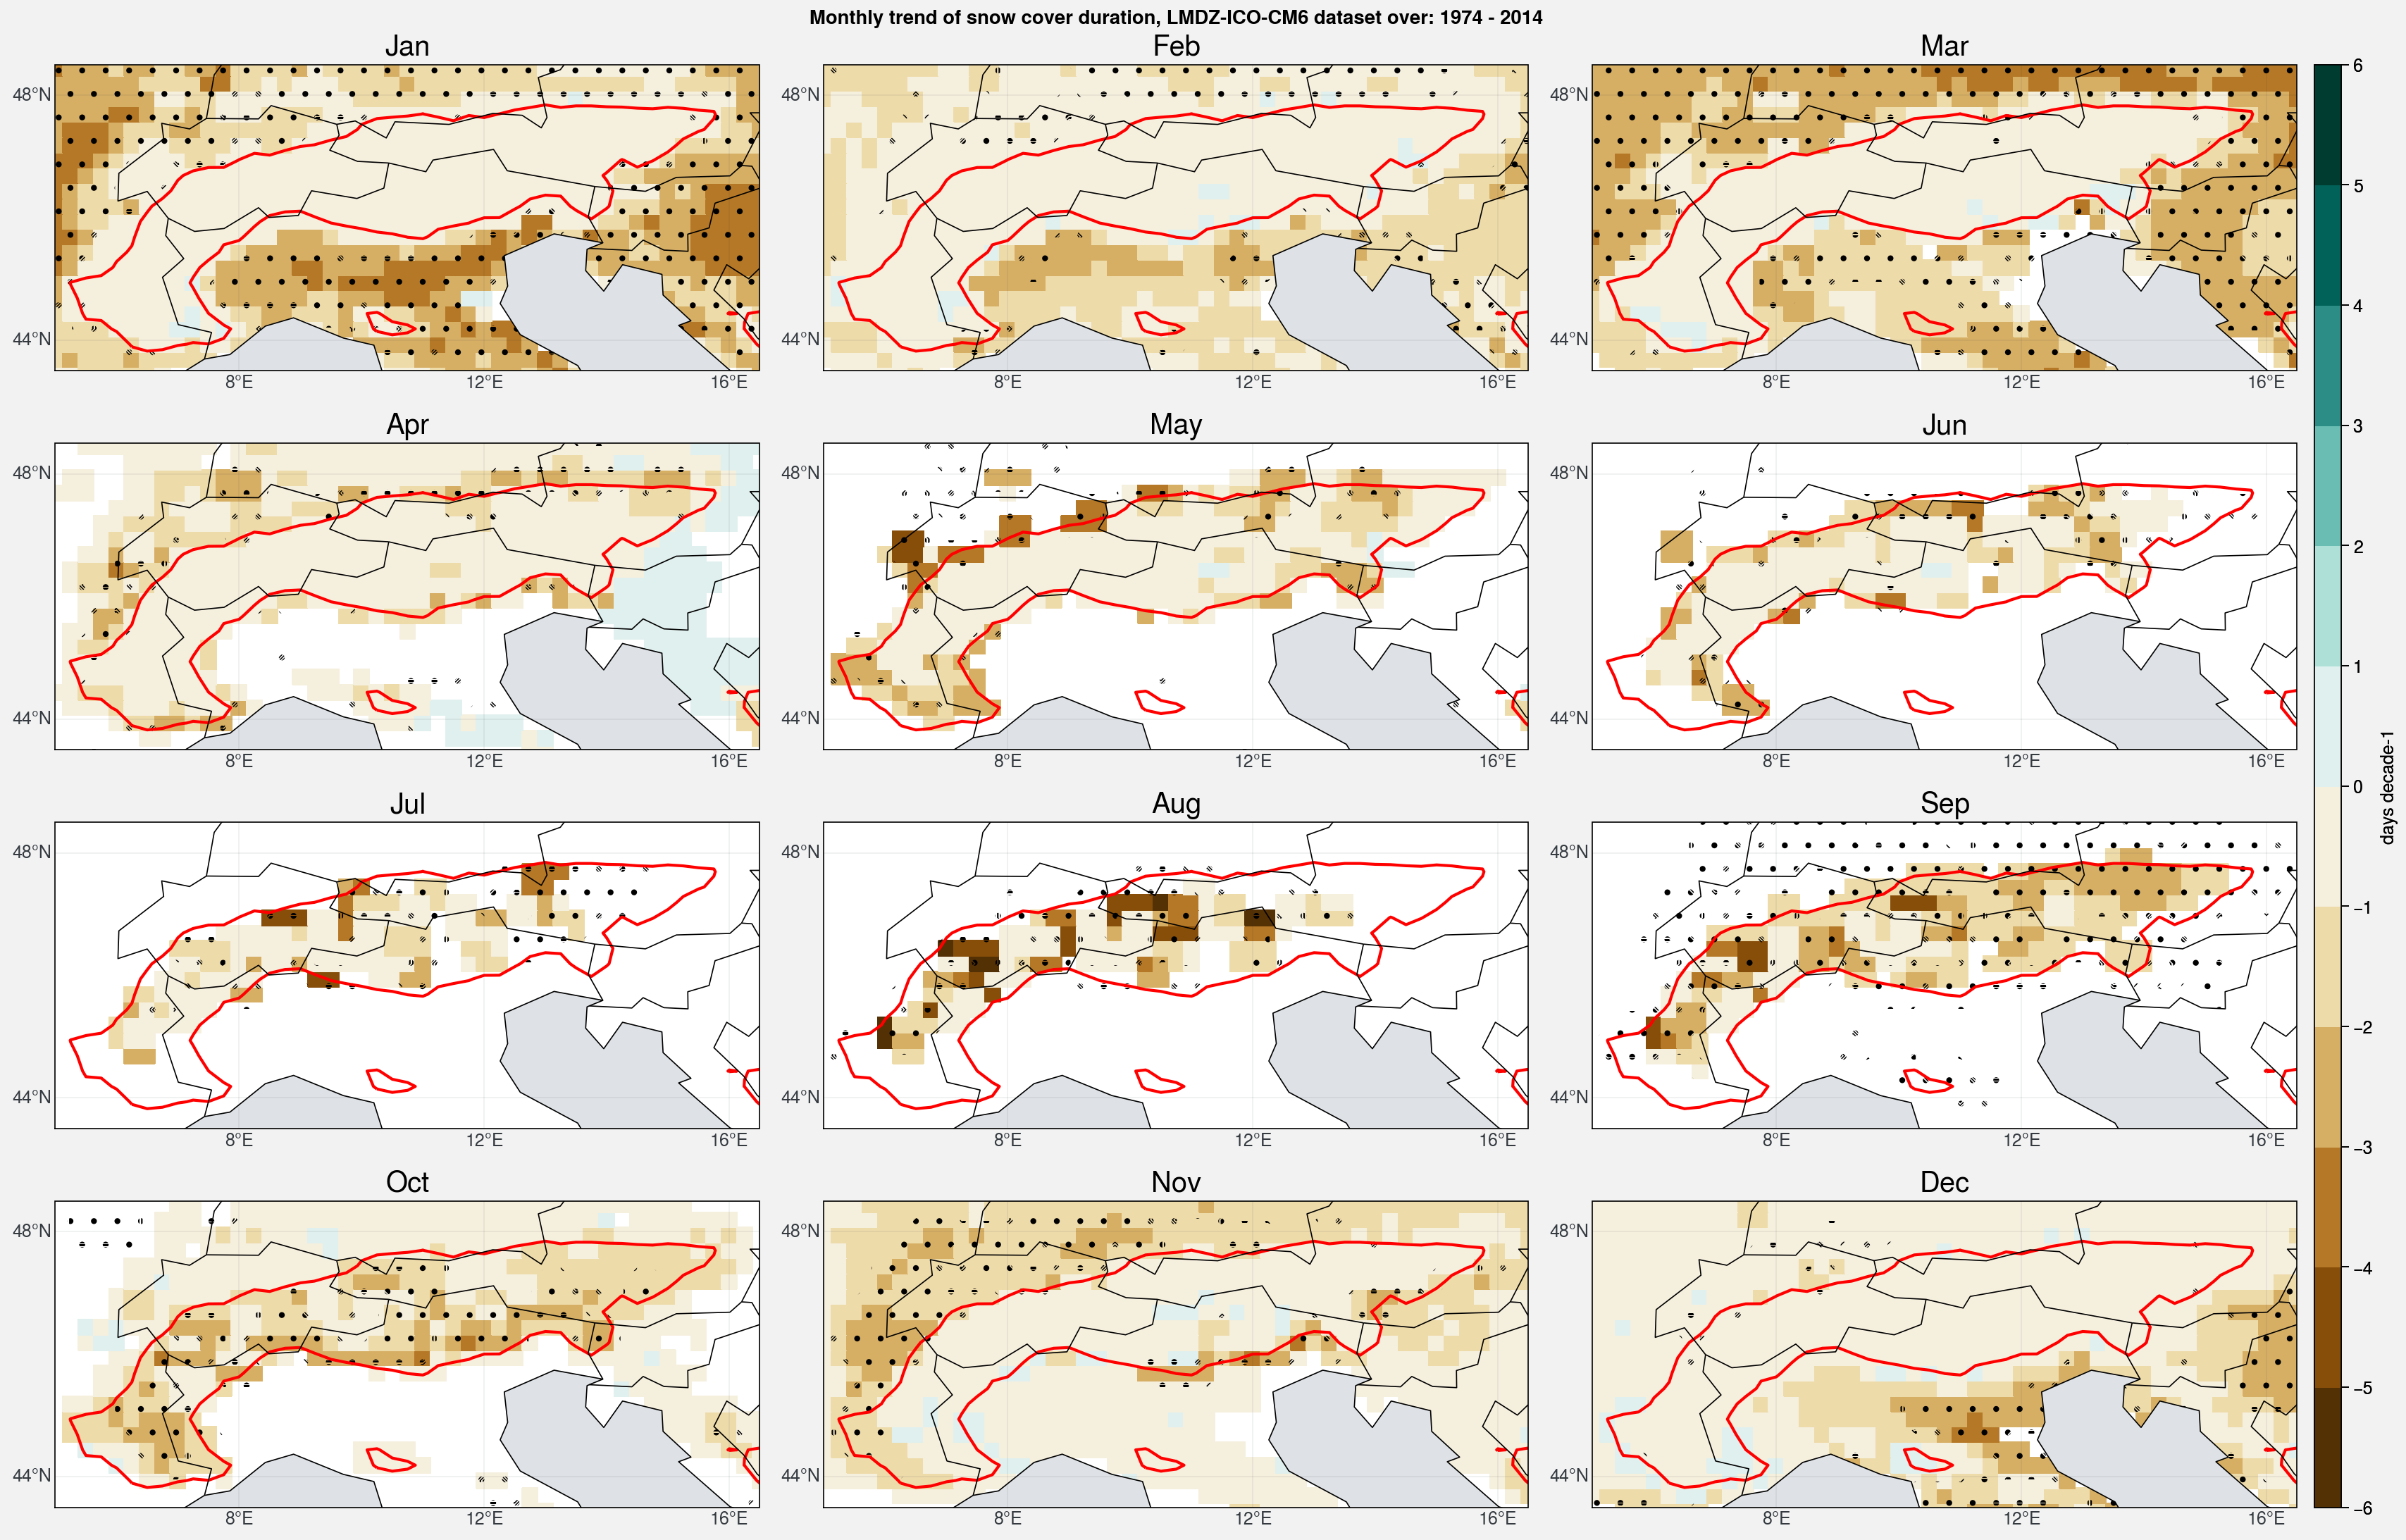

In [408]:
# Producing the map of the trends
f, axs = plot.subplots(proj='cyl',ncols=3, nrows=4, share=1, axwidth=5)
for i, ax in enumerate(axs):
    print('i='+str(i))
    print('ax='+str(ax))
    m = ax.pcolormesh(
        ds_nbdays.lon,ds_nbdays.lat,
        slope_nbdays[:,:,i]*factor*mask_snow[:,:,i],
        levels=levels,
        cmap='BrBg'
    )
    
    p = ax.contour(
        dsi_topo.lon,dsi_topo.lat,dsi_topo,
        levels=levels_elev,color='red',
    )
    
    ax.format(title=months[i],titlesize='20px')
    
    q = ax.contourf(
    ds_nbdays.lon,ds_nbdays.lat,
    signif[:,:,i],
    hatches=["", "."], alpha=0
    )
    
f.colorbar(m, label= 'days decade-1')

axs.format(
    gridlinewidth=0.1, gridcolor='gray8', gridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True, 
    suptitle="Monthly trend of snow cover duration, LMDZ-ICO-CM6 dataset over: "+str(first_year)+" - "+str(last_year),
    lonlines=4, latlines=4, abc=False, latlim=latlim,lonlim=lonlim,
)

filename = 'fig_snc_monthly_trends_'+area+'_'+str(first_year)+'_'+str(last_year)
f.save('img/LDMZ_ICO_CM6_snc/'+filename+'.png')

## 7. Yearly means and trends

In [409]:
yearly_mean_nbdays=np.nansum(monthly_mean_nbdays,axis=2)
yearly_slope_nbdays=np.nansum(slope_nbdays, axis=2)

In [410]:
levels=plot.arange(0,300,10)
levels_trends=plot.arange(-10,10,1)
yearly_factor=10 # Signal per decade

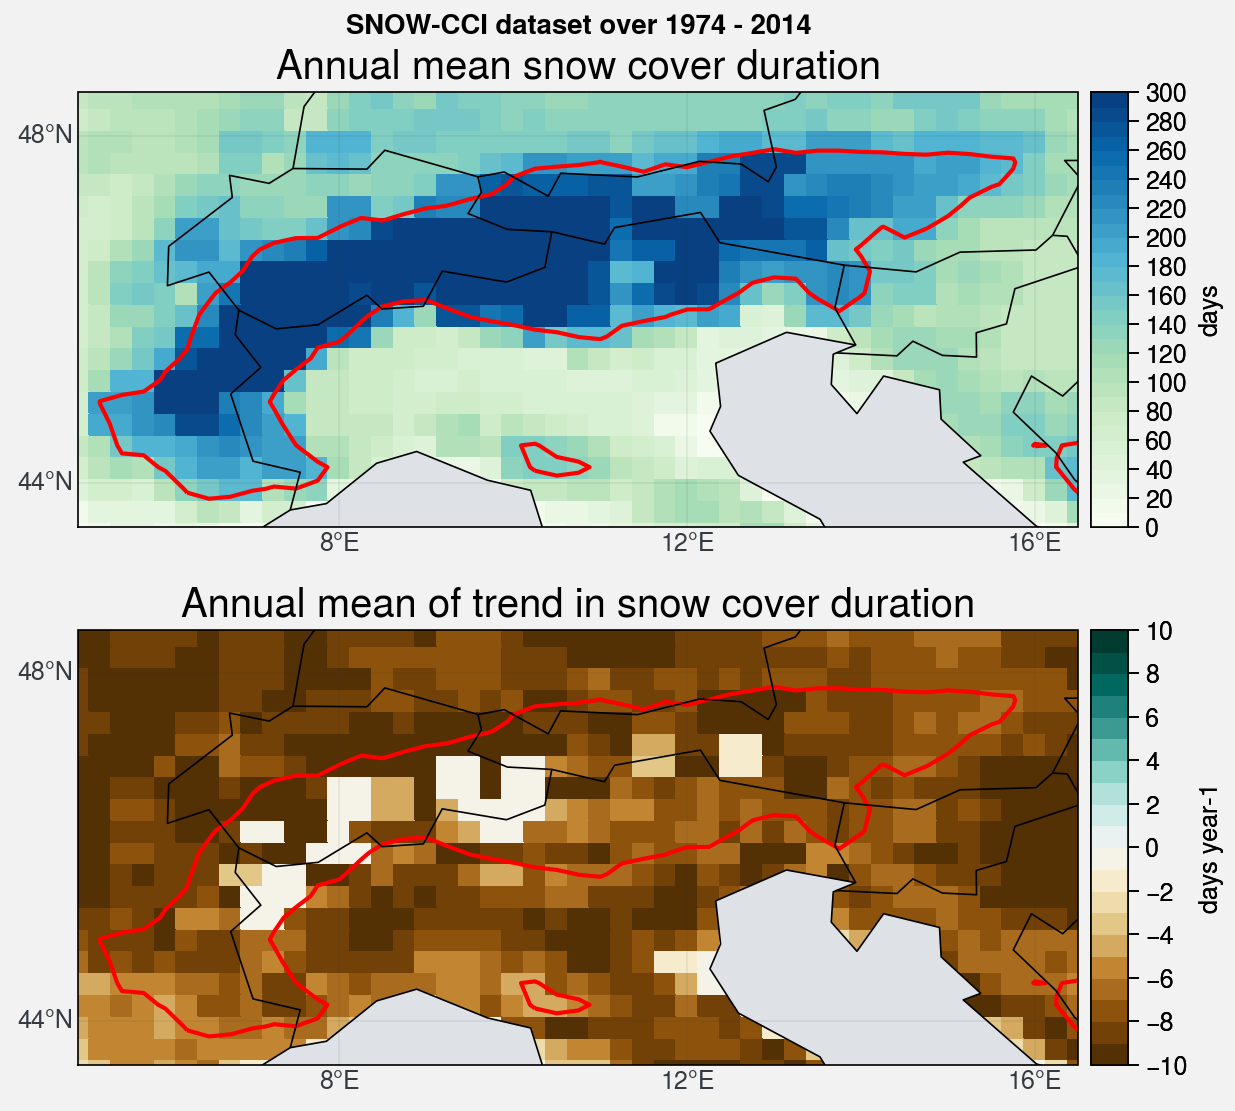

In [411]:
# Producing the map of the snow cover duration yearly mean and trends
f, axs = plot.subplots(proj='cyl',ncols=1, nrows=2, share=1, axwidth=5)

axs[0,0].pcolormesh(ds_nbdays.lon,ds_nbdays.lat,yearly_mean_nbdays,
                    cmap=cmap_mean,
                    levels=levels,
                    colorbar='r', colorbar_kw={'label': 'days'},
                   )

axs[0,0].contour(dsi_topo, levels=levels_elev,color='red')

axs[0,0].format(title='Annual mean snow cover duration',titlesize='20px')

axs[1,0].pcolormesh(ds_nbdays.lon,ds_nbdays.lat,yearly_slope_nbdays*yearly_factor,
                    cmap=cmap_trend,
                    levels=levels_trends,
                    colorbar='r', colorbar_kw={'label': 'days year-1'},
                   )
axs[1,0].contour(dsi_topo, levels=levels_elev,color='red')
axs[1,0].format(title='Annual mean of trend in snow cover duration',titlesize='20px')


axs.format(
    gridlinewidth=0.1, gridcolor='gray8', gridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="SNOW-CCI dataset over "+str(first_year)+" - "+str(last_year),
    lonlines=4, latlines=4, abc=False, latlim=latlim,lonlim=lonlim,
)

## 8. Trends as a function of elevation

In [412]:
# Levels of temperature for the plot
#levels=np.arange(-0.5,0.5,0.05)
factor_trend=10 # degree per decade
#bins=100
levels=np.logspace(0,1,25)

In [413]:
# We keep only the elevation area > limit m.asl
limit=1000
topo_high=dsi_topo.where(dsi_topo> limit)
trends_high=np.zeros(slope_nbdays.shape)
trends_high_signif=np.zeros(slope_nbdays.shape)
trends_high_no_signif=np.zeros(slope_nbdays.shape)
for i in np.arange(months_per_year):
    trends_high[:,:,i]=np.where(dsi_topo > limit,slope_nbdays[:,:,i],np.nan)
    trends_high_signif[:,:,i]=np.where(pvalue_nbdays[:,:,i] < 0.05,trends_high[:,:,i],np.nan)
    trends_high_no_signif[:,:,i]=np.where(pvalue_nbdays[:,:,i] >= 0.05,trends_high[:,:,i],np.nan)

# Pour vérif :
# lon_loc=6.4; lat_loc=45.0
# topo_high.sel(lon=lon_loc, method="nearest")

i=0
ax=CartesianAxesSubplot(0.0688889,0.774587;0.266667x0.203482)
i=1
ax=CartesianAxesSubplot(0.397778,0.774587;0.266667x0.203482)
i=2
ax=CartesianAxesSubplot(0.726667,0.774587;0.266667x0.203482)
i=3
ax=CartesianAxesSubplot(0.0688889,0.527131;0.266667x0.203482)
i=4
ax=CartesianAxesSubplot(0.397778,0.527131;0.266667x0.203482)
i=5
ax=CartesianAxesSubplot(0.726667,0.527131;0.266667x0.203482)
i=6
ax=CartesianAxesSubplot(0.0688889,0.279674;0.266667x0.203482)
i=7
ax=CartesianAxesSubplot(0.397778,0.279674;0.266667x0.203482)
i=8
ax=CartesianAxesSubplot(0.726667,0.279674;0.266667x0.203482)
i=9
ax=CartesianAxesSubplot(0.0688889,0.032218;0.266667x0.203482)
i=10
ax=CartesianAxesSubplot(0.397778,0.032218;0.266667x0.203482)
i=11
ax=CartesianAxesSubplot(0.726667,0.032218;0.266667x0.203482)


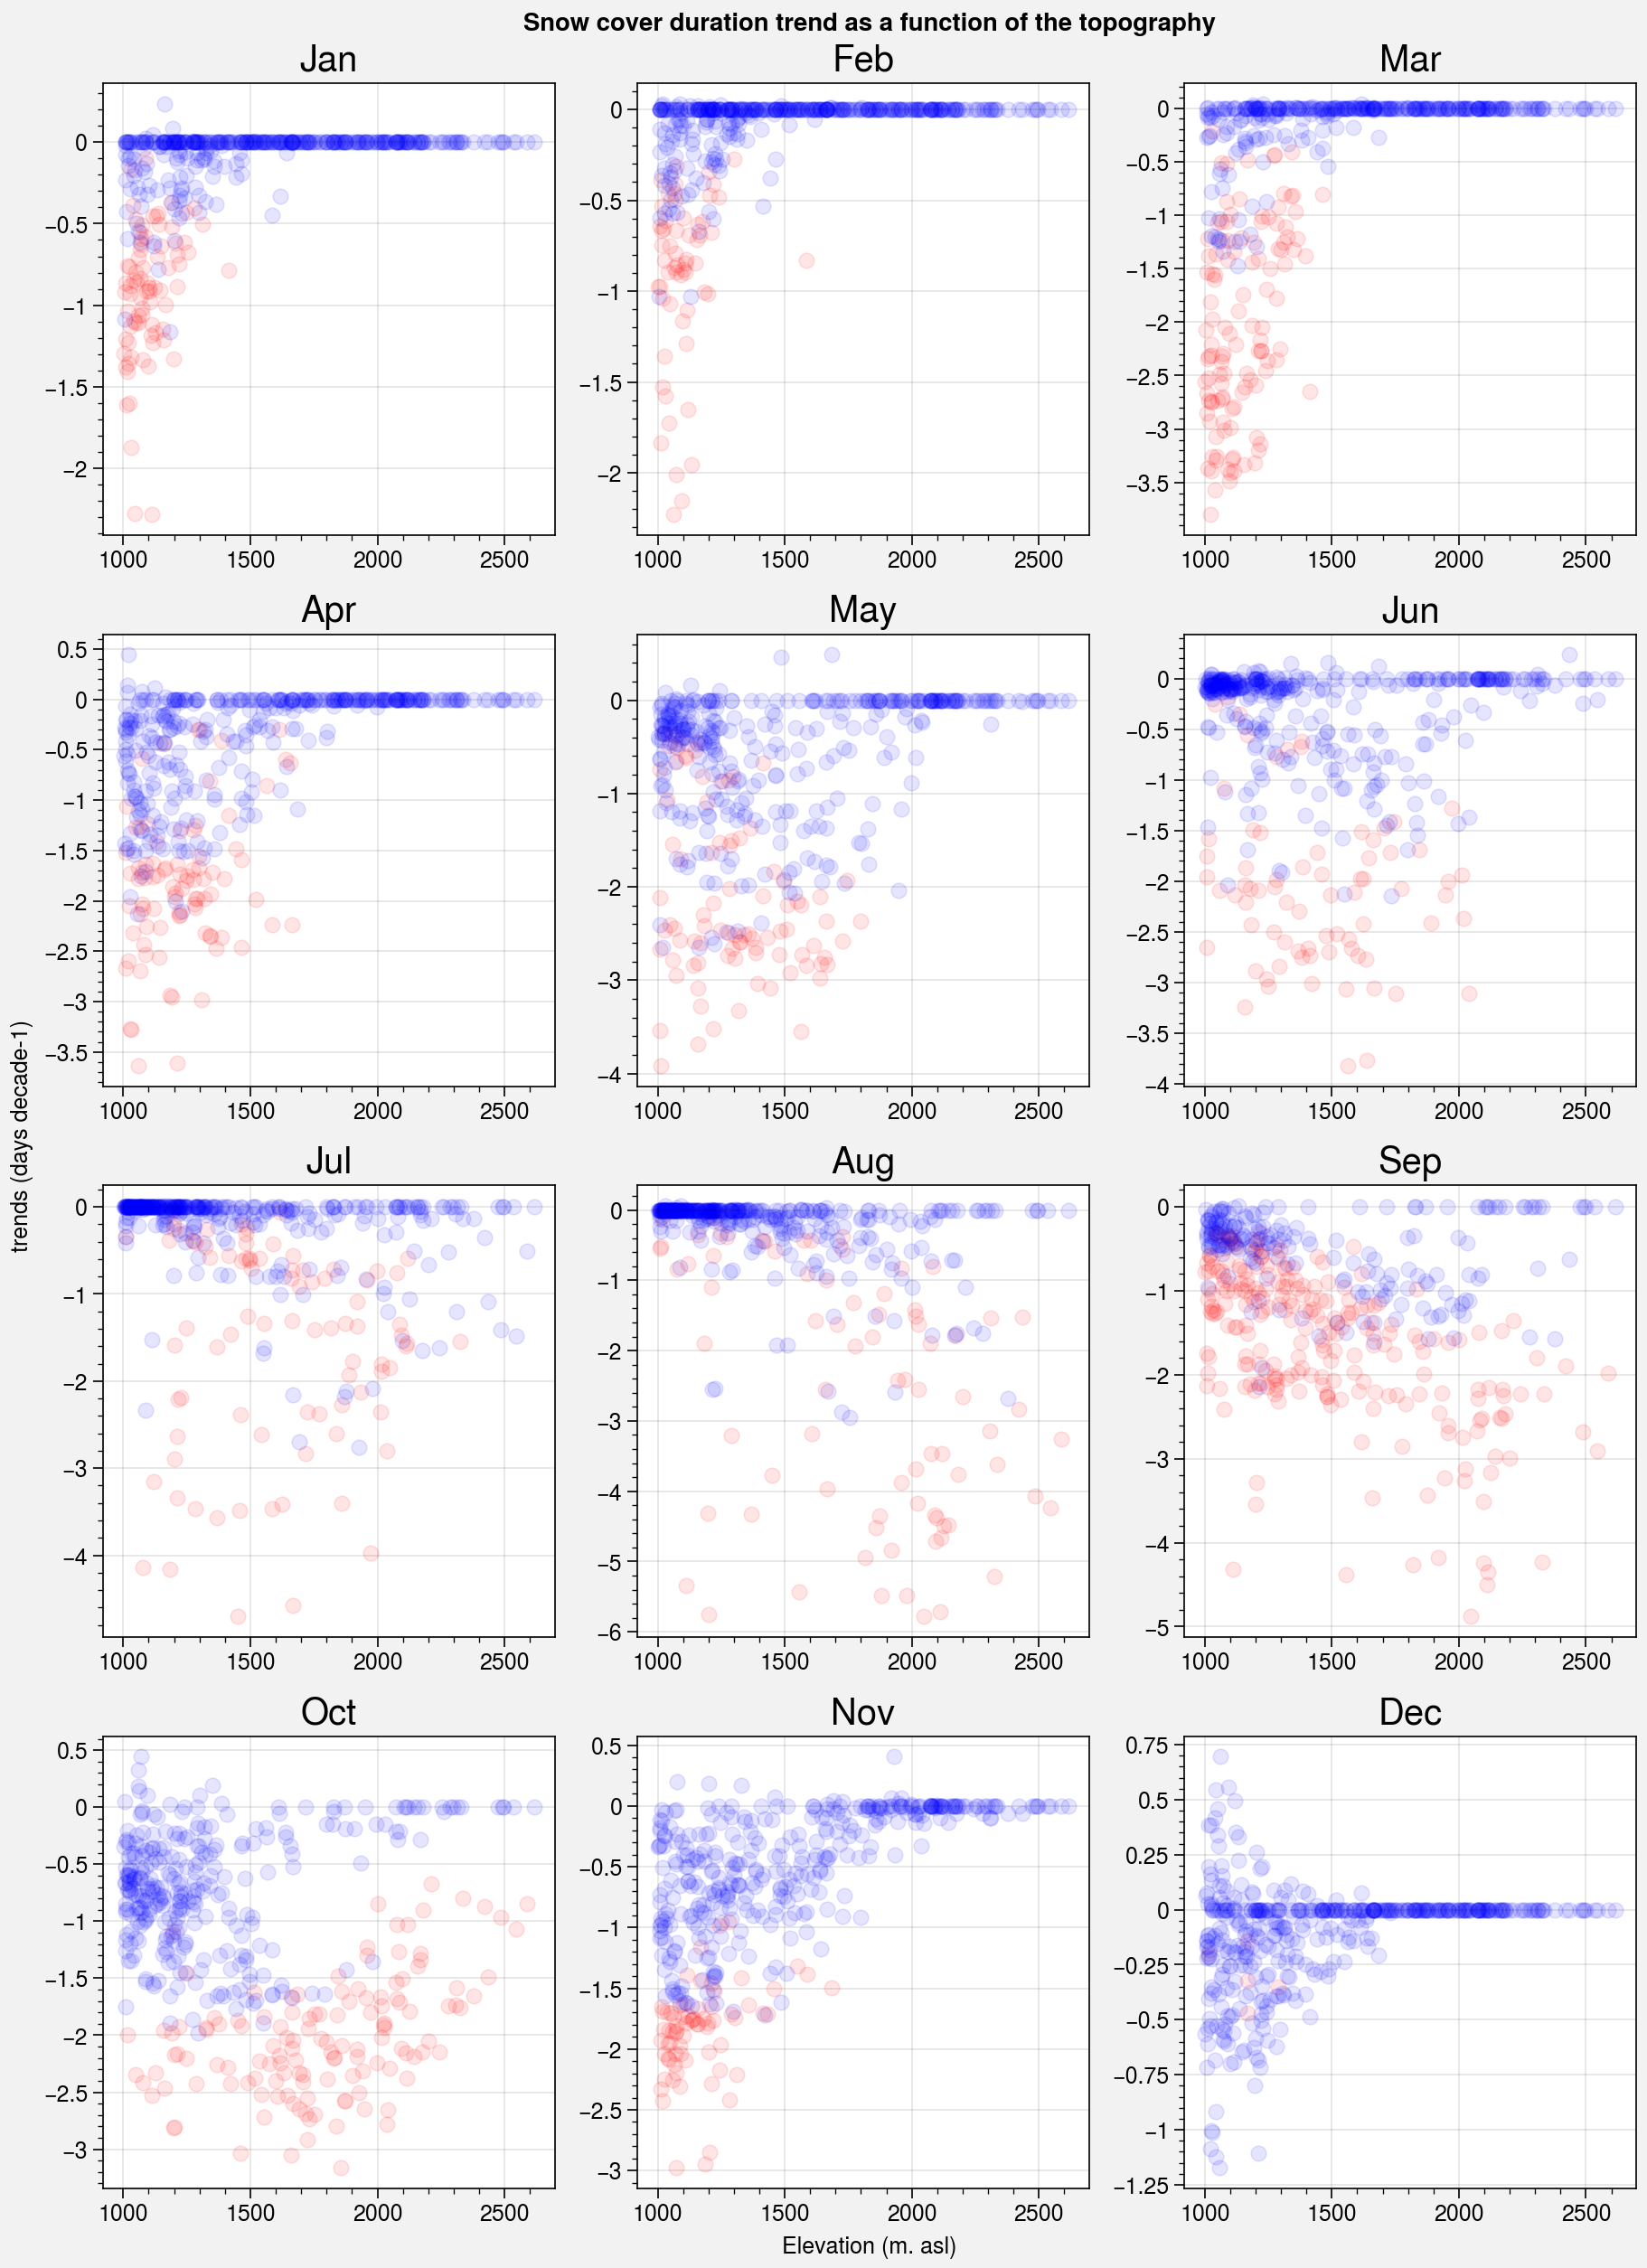

In [414]:
#Plotting trends as a function of elevation
f, axs = plot.subplots(ncols=3, nrows=4,share=1)
for i, ax in enumerate(axs):
    print('i='+str(i))
    print('ax='+str(ax))
    m = ax.scatter(topo_high.values.flatten(),trends_high_signif[:,:,i].flatten()*factor_trend,alpha=0.1,color='red')
    m = ax.scatter(topo_high.values.flatten(),trends_high_no_signif[:,:,i].flatten()*factor_trend,alpha=0.1,color='blue')
    ax.format(title=months[i],titlesize='20px')#,ylim=(-0.05,0.25))

axs.format(
    suptitle='Snow cover duration trend as a function of the topography',
    xlabel='Elevation (m. asl)',
    ylabel='trends (days decade-1)',
    titlesize='20px'
)

In [415]:
# client.close()